In [1]:
!python --version

Python 2.7.12 :: Anaconda 2.3.0 (x86_64)


In [19]:
import numpy as np
from astropy.table import Table, Column, vstack
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.stats import powerlaw
from scipy import integrate
from scipy.special import gammaln
import time
%matplotlib inline

In [3]:
def energies_rs(a,b,gamma,N):
    ''' Returns an array of photon energies with a power law distribution using rejection sampling.
        a = E_min
        b = E_max
        gamma = photon index
        N = total number of photons to be returned
    '''
    start_time = time.time()
    A = (1.-gamma)/((b**(1.-gamma))-(a**(1.-gamma))) #normalization factor so curve integrates to 1
    pl =  lambda x,A,gamma : A*x**(-1.0*gamma)
    binsize = 0.13 #keV, set by Chandra detector. This will be swapped out later for a more realistic binning
    bins = np.arange(a,b,binsize)
    photons = np.zeros(N)
    count = 0
    while count<N:
        r = np.random.uniform(a,b,1)
        for i in range(len(bins)-1):
            if (r>bins[i])and(r<bins[i+1]):
                edge_lo = bins[i]
                edge_hi = bins[i+1]
                p_r = integrate.quad(pl,edge_lo,edge_hi,args=(A,gamma))[0]
                k = np.random.uniform(0,1,1)
                if (k<=p_r):
                    photons[count] = r
                    count += 1
    print("Time to generate photon energies = %s seconds" % (time.time() - start_time))
    return photons

In [7]:
def energies_cdf(a,b,gamma,N):
    '''
    Generate photon energies using the cumulative distribution function (CDF)
    CDF taken from https://arxiv.org/pdf/0706.1062.pdf
    a = E_min
    b = E_max
    gamma = photon index
    N = total number of photons to be returned'''
    start_time = time.time()
    r = np.random.uniform(0,1,N)
    x = a*(1-r)**(-1/(gamma-1))
    print("Time to generate photon energies = %s seconds" % (time.time() - start_time))
    return x

Time to generate photon energies = 0.00324892997742 seconds


(array([  4.99020000e+04,   7.00000000e+01,   9.00000000e+00,
          6.00000000e+00,   7.00000000e+00,   3.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.00000000e+00]),
 array([  0.10000251,   3.84143819,   7.58287387,  11.32430955,
         15.06574523,  18.8071809 ,  22.54861658,  26.29005226,
         30.03148794,  33.77292362,  37.51435929]),
 <a list of 10 Patch objects>)

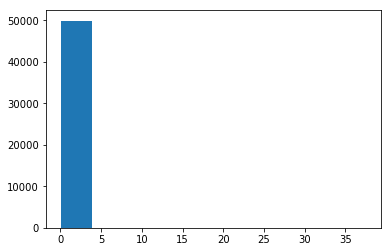

In [183]:
energies = energies_cdf(0.1,10.,2.7,50000)
plt.hist(energies)

Chandra ACIS energy resolution = 130-280 eV (http://cxc.harvard.edu/cal/Acis/)

In [4]:
def simulate_data(stop,handle):
    ''' Generates an un-piled and piled list of photon energies. 
        stop = end time of observation, generally equals total length of obs in seconds.
        handle = 'rs' to generate photons via rejection 
    '''
    #Assign physical parameters
    start = 0. #s
    #stop = 100 #s
    cr = 1. #count rate between 0.1 and 10 photons/second
    gamma = 2.7 #assume photon index
    read_time = 3.2 #s
    energy_lo = 0.1 #keV
    energy_hi = 10.0 #keV
    K = (stop-start)*cr #Number of photons to generate
    N = np.random.poisson(K) #choose a number of photons from a poisson distribution centered on expected, K
    print 'number of photons observed =', N
    
    #Assign photon arrival times, random within obervation time
    arrival_times = np.random.uniform(start,stop,N)
    
    #Assign photon energies, random with a power law distribution.
    if handle == 'rs':
        print 'generating photon energies via rejection sampling'
        energy = energies_rs(energy_lo,energy_hi,gamma,N) #generate photon energies using rejection sampling
    if handle == 'cdf':
        print 'generating photon energies via CDF method'
        energy = energies_cdf(energy_lo,energy_hi,gamma,N)
    else:
        print 'invalid photon generation method entered'
        
    #Simulate pile up: bin arrival times, if there is more than one photon in a bin, combine their energies
    #and record as one photon, change other photon energies to 0
    piled_energy = np.copy(energy)
    times = Column(arrival_times,name='time')
    energies = Column(energy,name='energy')
    raw = Table([times,energies])
    raw.sort('time')
    time_bins = np.arange(start,stop,read_time)
    time_hist, time_edges = np.histogram(raw['time'],bins=time_bins)
    num_piled = 0
    for i in range(len(time_hist)):
        if time_hist[i] > 1:
            #print time_hist[i]
            num_piled += time_hist[i]
            first_photon = np.sum(time_hist[0:i])
            last_photon = first_photon + time_hist[i] - 1
            sum_energy = np.sum(energies[first_photon:last_photon])
            piled_energy[first_photon] = sum_energy
            piled_energy[first_photon+1:last_photon] = 0.0
    print 'Fraction of photons that are piled =', np.float(num_piled) / N
    return energy, piled_energy

In [5]:
def plot_data(raw,piled):
    '''
    Takes output data from simulate_data() and plots the raw vs. piled spectra
    '''
    arf = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.corr.arf',format='fits')
    fig,ax=plt.subplots(figsize=(8,5))
    #num=len(raw)/50.
    e_hist, e_bins = np.histogram(raw,bins=arf['ENERG_HI'])
    pe_hist, pe_bins = np.histogram(piled[piled>0],bins=arf['ENERG_HI'])
    ax.plot(e_bins[1:],e_hist,label='un-piled')
    ax.plot(pe_bins[1:],pe_hist,label='piled')
    ax.set_xlabel('Energy (keV)')
    ax.set_xlim(-0.5,11)
    ax.set_ylabel('Flux, unscaled')
    ax.set_yscale('log')
    ax.legend()
    return e_hist, pe_hist

In [ ]:
energy,piled_energy = simulate_data(5000,'rs')
plot_data(energy,piled_energy)

number of photons observed = 498873
generating photon energies via CDF method
Time to generate photon energies = 0.0312449932098 seconds
Fraction of photons that are piled = 0.958931431446


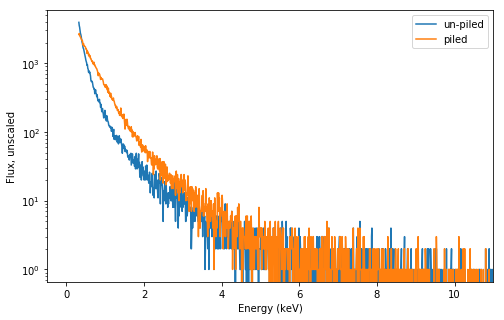

In [8]:
energy,piled_energy = simulate_data(500000,'cdf')
energy_hist, piled_hist = plot_data(energy,piled_energy)

In [9]:
pi_file = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.pi',format='fits')
rmf = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.rmf',format='fits')
arf = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.corr.arf',format='fits')
E_min = arf['ENERG_LO']
E_max = arf['ENERG_HI']

In [32]:
print gammaln(7)
print np.log(1)+np.log(2)+np.log(3)+np.log(4)+np.log(5)+np.log(6)
test = np.array([1,2,3])
new_test = test+1
print gammaln(test+1),gammaln(new_test)

6.57925121201
6.57925121201
[ 0.          0.69314718  1.79175947] [ 0.          0.69314718  1.79175947]


In [13]:
def integrate_lambda(E_array,A,alpha):
    """ Takes in array of energy bin edges, value of A and alpha and returns finite integral"""
    integral = A/(1-alpha) * np.power(E,1-alpha)
    return integral

In [10]:
def log_likelihood(data,logA,a,E_min,E_max):
    """
    Return log(Poisson likelihood) function for dataset
    Poisson probability of the form P(k) = exp(-lambda)*lambda**k/k!
    lambda = integral from E_min to E_max A*E**-a
    input data = piled histogram from previous step
    """
    start_time = time.time()
    #Move this outside the function add E_min and E_max as input to the function
    lam = integrate_lambda(E_max,np.exp(logA),a) - integrate_lambda(E_min,np.exp(logA),a)
    summation = gammaln(data+1)
    log_like = np.multiply(-1.0,lam) + data*np.log(lam) + summation
    total_log_like = np.sum(log_like)
    #print("Time to calculate log(likelihood) = %s seconds" % (time.time() - start_time))
    if not np.isfinite(total_log_like):
        return -np.inf
    else:
        return total_log_like

In [68]:
def log_prior_alpha(a):
    if (a > 0) and (a<5):
        return np.log(0.2)
    else:
        return -np.inf
def log_prior_logA(logA):
    if (logA<np.log(1000000))and(logA>np.log(100)):
        return np.log(1.0/(np.log(1000000)-np.log(100)))
    else:
        return -np.inf

In [69]:
log_prior_logA(500000)

-2.2203268063678463

In [72]:
test_A = 500000
test_alpha = 2.0
print log_likelihood(piled_hist,np.log(test_A),test_alpha) + log_prior_alpha(test_alpha) + log_prior_logA(np.log(test_A))

68242683.8787


In [54]:
log_likelihood(piled_hist,np.log(50000),1.8)

Time to calculate log(likelihood) = 0.150687932968 seconds


69448176.683093965

In [64]:
A = np.linspace(0,1000000,10)
a = np.linspace(0,5,10)
max_ll = 0
best = [0,0]
count = 0
for i in range(len(A)):
    for j in range(len(a)):
        running_ll = log_likelihood(piled_hist,np.log(A[i]),a[j])
        count += 1
        if count%len(A) == 0:
            print 'working on round ',count
        if running_ll > max_ll:
            max_ll = running_ll
            best = [i,j]
print 'best fit for values of A=',A[best[0]],a[best[1]], 'log(likelihood)=',max_ll

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in multiply


working on round  10
working on round  20
working on round  30
working on round  40
working on round  50
working on round  60
working on round  70
working on round  80
working on round  90
working on round  100
best fit for values of A= 111111.111111 1.66666666667 log(likelihood)= 69345843.7892
